## 1. Likelihood for the Multi-nomial Logit (MNL) Model

Suppose we have $i=1,\ldots,n$ consumers who each select exactly one product $j$ from a set of $J$ products. The outcome variable is the identity of the product chosen $y_i \in \{1, \ldots, J\}$ or equivalently a vector of $J-1$ zeros and $1$ one, where the $1$ indicates the selected product. For example, if the third product was chosen out of 3 products, then either $y=3$ or $y=(0,0,1)$ depending on how we want to represent it. Suppose also that we have a vector of data on each product $x_j$ (eg, brand, price, etc.). 

We model the consumer's decision as the selection of the product that provides the most utility, and we'll specify the utility function as a linear function of the product characteristics:

$$ U_{ij} = x_j'\beta + \epsilon_{ij} $$

where $\epsilon_{ij}$ is an i.i.d. extreme value error term. 

The choice of the i.i.d. extreme value error term leads to a closed-form expression for the probability that consumer $i$ chooses product $j$:

$$ \mathbb{P}_i(j) = \frac{e^{x_j'\beta}}{\sum_{k=1}^Je^{x_k'\beta}} $$

For example, if there are 3 products, the probability that consumer $i$ chooses product 3 is:

$$ \mathbb{P}_i(3) = \frac{e^{x_3'\beta}}{e^{x_1'\beta} + e^{x_2'\beta} + e^{x_3'\beta}} $$

A clever way to write the individual likelihood function for consumer $i$ is the product of the $J$ probabilities, each raised to the power of an indicator variable ($\delta_{ij}$) that indicates the chosen product:

$$ L_i(\beta) = \prod_{j=1}^J \mathbb{P}_i(j)^{\delta_{ij}} = \mathbb{P}_i(1)^{\delta_{i1}} \times \ldots \times \mathbb{P}_i(J)^{\delta_{iJ}}$$

Notice that if the consumer selected product $j=3$, then $\delta_{i3}=1$ while $\delta_{i1}=\delta_{i2}=0$ and the likelihood is:

$$ L_i(\beta) = \mathbb{P}_i(1)^0 \times \mathbb{P}_i(2)^0 \times \mathbb{P}_i(3)^1 = \mathbb{P}_i(3) = \frac{e^{x_3'\beta}}{\sum_{k=1}^3e^{x_k'\beta}} $$

The joint likelihood (across all consumers) is the product of the $n$ individual likelihoods:

$$ L_n(\beta) = \prod_{i=1}^n L_i(\beta) = \prod_{i=1}^n \prod_{j=1}^J \mathbb{P}_i(j)^{\delta_{ij}} $$

And the joint log-likelihood function is:

$$ \ell_n(\beta) = \sum_{i=1}^n \sum_{j=1}^J \delta_{ij} \log(\mathbb{P}_i(j)) $$



## 2. Simulate Conjoint Data

We will simulate data from a conjoint experiment about video content streaming services. We elect to simulate 100 respondents, each completing 10 choice tasks, where they choose from three alternatives per task. For simplicity, there is not a "no choice" option; each simulated respondent must select one of the 3 alternatives. 

Each alternative is a hypothetical streaming offer consistent of three attributes: (1) brand is either Netflix, Amazon Prime, or Hulu; (2) ads can either be part of the experience, or it can be ad-free, and (3) price per month ranges from \$4 to \$32 in increments of \$4.

The part-worths (ie, preference weights or beta parameters) for the attribute levels will be 1.0 for Netflix, 0.5 for Amazon Prime (with 0 for Hulu as the reference brand); -0.8 for included adverstisements (0 for ad-free); and -0.1*price so that utility to consumer $i$ for hypothethical streaming service $j$ is 

$$
u_{ij} = (1 \times Netflix_j) + (0.5 \times Prime_j) + (-0.8*Ads_j) - 0.1\times Price_j + \varepsilon_{ij}
$$

where the variables are binary indicators and $\varepsilon$ is Type 1 Extreme Value (ie, Gumble) distributed.

The following code provides the simulation of the conjoint data.



In [1]:

# set seed for reproducibility
set.seed(123)

# define attributes
brand <- c("N", "P", "H") # Netflix, Prime, Hulu
ad <- c("Yes", "No")
price <- seq(8, 32, by=4)

# generate all possible profiles
profiles <- expand.grid(
    brand = brand,
    ad = ad,
    price = price
)
m <- nrow(profiles)

# assign part-worth utilities (true parameters)
b_util <- c(N = 1.0, P = 0.5, H = 0)
a_util <- c(Yes = -0.8, No = 0.0)
p_util <- function(p) -0.1 * p

# number of respondents, choice tasks, and alternatives per task
n_peeps <- 100
n_tasks <- 10
n_alts <- 3

# function to simulate one respondent’s data
sim_one <- function(id) {
  
    datlist <- list()
    
    # loop over choice tasks
    for (t in 1:n_tasks) {
        
        # randomly sample 3 alts (better practice would be to use a design)
        dat <- cbind(resp=id, task=t, profiles[sample(m, size=n_alts), ])
        
        # compute deterministic portion of utility
        dat$v <- b_util[dat$brand] + a_util[dat$ad] + p_util(dat$price) |> round(10)
        
        # add Gumbel noise (Type I extreme value)
        dat$e <- -log(-log(runif(n_alts)))
        dat$u <- dat$v + dat$e
        
        # identify chosen alternative
        dat$choice <- as.integer(dat$u == max(dat$u))
        
        # store task
        datlist[[t]] <- dat
    }
    
    # combine all tasks for one respondent
    do.call(rbind, datlist)
}

# simulate data for all respondents
conjoint_data <- do.call(rbind, lapply(1:n_peeps, sim_one))

# remove values unobservable to the researcher
conjoint_data <- conjoint_data[ , c("resp", "task", "brand", "ad", "price", "choice")]

# clean up
rm(list=setdiff(ls(), "conjoint_data"))
```


SyntaxError: invalid syntax (3640094256.py, line 28)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## 3. Preparing the Data for Estimation

The "hard part" of the MNL likelihood function is organizing the data, as we need to keep track of 3 dimensions (consumer $i$, covariate $k$, and product $j$) instead of the typical 2 dimensions for cross-sectional regression models (consumer $i$ and covariate $k$). The fact that each task for each respondent has the same number of alternatives (3) helps.  In addition, we need to convert the categorical variables for brand and ads into binary variables.

_todo: reshape and prep the data_

In [14]:
import pandas as pd
conjoint_data = pd.read_csv("conjoint_data.csv")
conjoint_data.head()

,resp,task,choice,brand,ad,price
0,1,1,1,N,Yes,28
1,1,1,0,H,Yes,16
2,1,1,0,P,Yes,16
3,1,2,0,N,Yes,32
4,1,2,1,P,Yes,16


In [ ]:
# Convert categorical variables to binary indicators
conjoint_data['netflix'] = (conjoint_data['brand'] == 'N').astype(int)
conjoint_data['prime'] = (conjoint_data['brand'] == 'P').astype(int)
conjoint_data['ads'] = (conjoint_data['ad'] == 'Yes').astype(int)

# Create design matrix X
X = conjoint_data[['netflix', 'prime', 'ads', 'price']].values
y = conjoint_data['choice'].values

# Create task identifiers
conjoint_data['resp_task'] = conjoint_data['resp'].astype(str) + "_" + conjoint_data['task'].astype(str)
task_ids = conjoint_data['resp_task'].values




Data preparation complete!


In [16]:
conjoint_data.head()

,resp,task,choice,brand,ad,price,netflix,prime,ads,resp_task
0,1,1,1,N,Yes,28,1,0,1,1_1
1,1,1,0,H,Yes,16,0,0,1,1_1
2,1,1,0,P,Yes,16,0,1,1,1_1
3,1,2,0,N,Yes,32,1,0,1,1_2
4,1,2,1,P,Yes,16,0,1,1,1_2


## 4. Estimation via Maximum Likelihood

_todo: Code up the log-likelihood function._

_todo: Use `optim()` in R or `scipy.optimize()` in Python to find the MLEs for the 4 parameters ($\beta_\text{netflix}$, $\beta_\text{prime}$, $\beta_\text{ads}$, $\beta_\text{price}$), as well as their standard errors (from the Hessian). For each parameter construct a 95% confidence interval._

In [17]:
def log_likelihood_mnl(beta, X, y, task_ids):
    """Calculate log-likelihood for MNL model"""
    # Calculate linear predictors
    V = X @ beta
    
    ll = 0
    unique_tasks = np.unique(task_ids)
    
    for task in unique_tasks:
        # Get indices for this task
        task_idx = (task_ids == task)
        V_task = V[task_idx]
        y_task = y[task_idx]
        
        # Calculate choice probabilities using softmax
        V_max = np.max(V_task)  # for numerical stability
        exp_V = np.exp(V_task - V_max)
        probs = exp_V / np.sum(exp_V)
        
        # Add to log-likelihood (only for chosen alternative)
        chosen_idx = np.where(y_task == 1)[0]
        if len(chosen_idx) == 1:
            ll += np.log(probs[chosen_idx[0]])
    
    return ll
def neg_log_likelihood(beta, X, y, task_ids):
    """Negative log-likelihood for optimization"""
    return -log_likelihood_mnl(beta, X, y, task_ids)

# Starting values
beta_start = np.array([0.0, 0.0, 0.0, 0.0])

# Maximum likelihood estimation
mle_result = minimize(
    neg_log_likelihood,
    beta_start,
    args=(X, y, task_ids),
    method='BFGS',
    options={'disp': False}
)

# Extract MLE estimates
beta_mle = mle_result.x
param_names = ['netflix', 'prime', 'ads', 'price']

# Calculate Hessian numerically for standard errors
def hessian_numerical(f, x, args, h=1e-5):
    """Calculate numerical Hessian"""
    n = len(x)
    H = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            x_pp = x.copy(); x_pp[i] += h; x_pp[j] += h
            x_pm = x.copy(); x_pm[i] += h; x_pm[j] -= h
            x_mp = x.copy(); x_mp[i] -= h; x_mp[j] += h
            x_mm = x.copy(); x_mm[i] -= h; x_mm[j] -= h
            
            H[i,j] = (f(x_pp, *args) - f(x_pm, *args) - f(x_mp, *args) + f(x_mm, *args)) / (4 * h**2)
    
    return H

# Calculate Hessian and standard errors
hessian = hessian_numerical(neg_log_likelihood, beta_mle, (X, y, task_ids))
se_mle = np.sqrt(np.diag(np.linalg.inv(hessian)))

# Calculate 95% confidence intervals
ci_lower = beta_mle - 1.96 * se_mle
ci_upper = beta_mle + 1.96 * se_mle

# Display MLE results
print("\n=== MAXIMUM LIKELIHOOD ESTIMATION RESULTS ===")
print("True parameters: Netflix=1.0, Prime=0.5, Ads=-0.8, Price=-0.1\n")

mle_results_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimate': np.round(beta_mle, 4),
    'SE': np.round(se_mle, 4),
    'CI_Lower': np.round(ci_lower, 4),
    'CI_Upper': np.round(ci_upper, 4)
})
print(mle_results_df.to_string(index=False))




=== MAXIMUM LIKELIHOOD ESTIMATION RESULTS ===
True parameters: Netflix=1.0, Prime=0.5, Ads=-0.8, Price=-0.1

Parameter  Estimate     SE  CI_Lower  CI_Upper
  netflix    0.9412 0.1110    0.7236    1.1588
    prime    0.5016 0.1111    0.2839    0.7194
      ads   -0.7320 0.0878   -0.9041   -0.5599
    price   -0.0995 0.0063   -0.1119   -0.0871


## 5. Estimation via Bayesian Methods

_todo: code up a metropolis-hasting MCMC sampler of the posterior distribution. Take 11,000 steps and throw away the first 1,000, retaining the subsequent 10,000._

_hint: Use N(0,5) priors for the betas on the binary variables, and a N(0,1) prior for the price beta._

_hint: instead of calculating post=lik*prior, you can work in the log-space and calculate log-post = log-lik + log-prior (this should enable you to re-use your log-likelihood function from the MLE section just above)_

_hint: King Markov (in the video) use a candidate distribution of a coin flip to decide whether to move left or right among his islands.  Unlike King Markov, we have 4 dimensions (because we have 4 betas) and our dimensions are continuous.  So, use a multivariate normal distribution to pospose the next location for the algorithm to move to. I recommend a MNV(mu, Sigma) where mu=c(0,0,0,0) and sigma has diagonal values c(0.05, 0.05, 0.05, 0.005) and zeros on the off-diagonal.  Since this MVN has no covariances, you can sample each dimension independently (so 4 univariate normals instead of 1 multivariate normal), where the first 3 univariate normals are N(0,0.05) and the last one if N(0,0.005)._


_todo: for at least one of the 4 parameters, show the trace plot of the algorithm, as well as the histogram of the posterior distribution._

_todo: report the 4 posterior means, standard deviations, and 95% credible intervals and compare them to your results from the Maximum Likelihood approach._


In [19]:
from scipy.stats import norm

def log_prior(beta):
    """Log-prior function with specified priors"""
    # N(0,5) priors for binary variables (netflix, prime, ads)
    # N(0,1) prior for price
    ll_prior = (norm.logpdf(beta[0], 0, 5) +
                norm.logpdf(beta[1], 0, 5) +
                norm.logpdf(beta[2], 0, 5) +
                norm.logpdf(beta[3], 0, 1))
    return ll_prior

def log_posterior(beta, X, y, task_ids):
    """Log-posterior function"""
    ll = log_likelihood_mnl(beta, X, y, task_ids)
    lp = log_prior(beta)
    return ll + lp

def metropolis_hastings_mcmc(n_iter, X, y, task_ids, beta_init=None):
    """Metropolis-Hastings MCMC sampler"""
    
    # Initialize
    if beta_init is None:
        beta_current = np.array([0.0, 0.0, 0.0, 0.0])
    else:
        beta_current = beta_init.copy()
    
    # Proposal covariance (diagonal as suggested)
    proposal_sd = np.array([0.05, 0.05, 0.05, 0.005])
    
    # Storage for samples
    samples = np.zeros((n_iter, 4))
    n_accepted = 0
    
    # Current log-posterior
    log_post_current = log_posterior(beta_current, X, y, task_ids)
    
    print("Starting MCMC sampling...")
    
    for i in range(n_iter):
        # Propose new state
        beta_proposed = beta_current + np.random.normal(0, proposal_sd, 4)
        
        # Calculate log-posterior for proposed state
        try:
            log_post_proposed = log_posterior(beta_proposed, X, y, task_ids)
            
            # Calculate acceptance probability
            log_alpha = min(0, log_post_proposed - log_post_current)
            
            # Accept or reject
            if np.log(np.random.rand()) < log_alpha:
                beta_current = beta_proposed
                log_post_current = log_post_proposed
                n_accepted += 1
            
        except:
            # If calculation fails, reject proposal
            pass
        
        # Store sample
        samples[i] = beta_current
        
        # Print progress
        if (i + 1) % 1000 == 0:
            acceptance_rate = n_accepted / (i + 1)
            print(f"Iteration {i+1:5d}, Acceptance rate: {acceptance_rate:.3f}")
    
    acceptance_rate = n_accepted / n_iter
    print(f"Final acceptance rate: {acceptance_rate:.3f}")
    
    return samples, acceptance_rate

# Run MCMC
n_total = 11000
n_burnin = 1000

# Start from MLE estimates for better convergence
samples_all, acceptance_rate = metropolis_hastings_mcmc(
    n_total, X, y, task_ids, beta_init=beta_mle
)

# Remove burn-in
samples = samples_all[n_burnin:]
n_keep = len(samples)

print(f"\nMCMC complete! Kept {n_keep} samples after burn-in.")

# Calculate posterior statistics
posterior_means = np.mean(samples, axis=0)
posterior_sds = np.std(samples, axis=0)
posterior_ci_lower = np.percentile(samples, 2.5, axis=0)
posterior_ci_upper = np.percentile(samples, 97.5, axis=0)

# Display Bayesian results
print("\n=== BAYESIAN MCMC ESTIMATION RESULTS ===")
bayesian_results_df = pd.DataFrame({
    'Parameter': param_names,
    'Post_Mean': np.round(posterior_means, 4),
    'Post_SD': np.round(posterior_sds, 4),
    'CI_Lower': np.round(posterior_ci_lower, 4),
    'CI_Upper': np.round(posterior_ci_upper, 4)
})
print(bayesian_results_df.to_string(index=False))

Starting MCMC sampling...
Iteration  1000, Acceptance rate: 0.568
Iteration  2000, Acceptance rate: 0.552
Iteration  3000, Acceptance rate: 0.554
Iteration  4000, Acceptance rate: 0.554
Iteration  5000, Acceptance rate: 0.554
Iteration  6000, Acceptance rate: 0.556
Iteration  7000, Acceptance rate: 0.557
Iteration  8000, Acceptance rate: 0.559
Iteration  9000, Acceptance rate: 0.560
Iteration 10000, Acceptance rate: 0.562
Iteration 11000, Acceptance rate: 0.561
Final acceptance rate: 0.561

MCMC complete! Kept 10000 samples after burn-in.

=== BAYESIAN MCMC ESTIMATION RESULTS ===
Parameter  Post_Mean  Post_SD  CI_Lower  CI_Upper
  netflix     0.9452   0.1146    0.7097    1.1669
    prime     0.5029   0.1144    0.2800    0.7415
      ads    -0.7268   0.0891   -0.9013   -0.5534
    price    -0.0995   0.0065   -0.1123   -0.0869


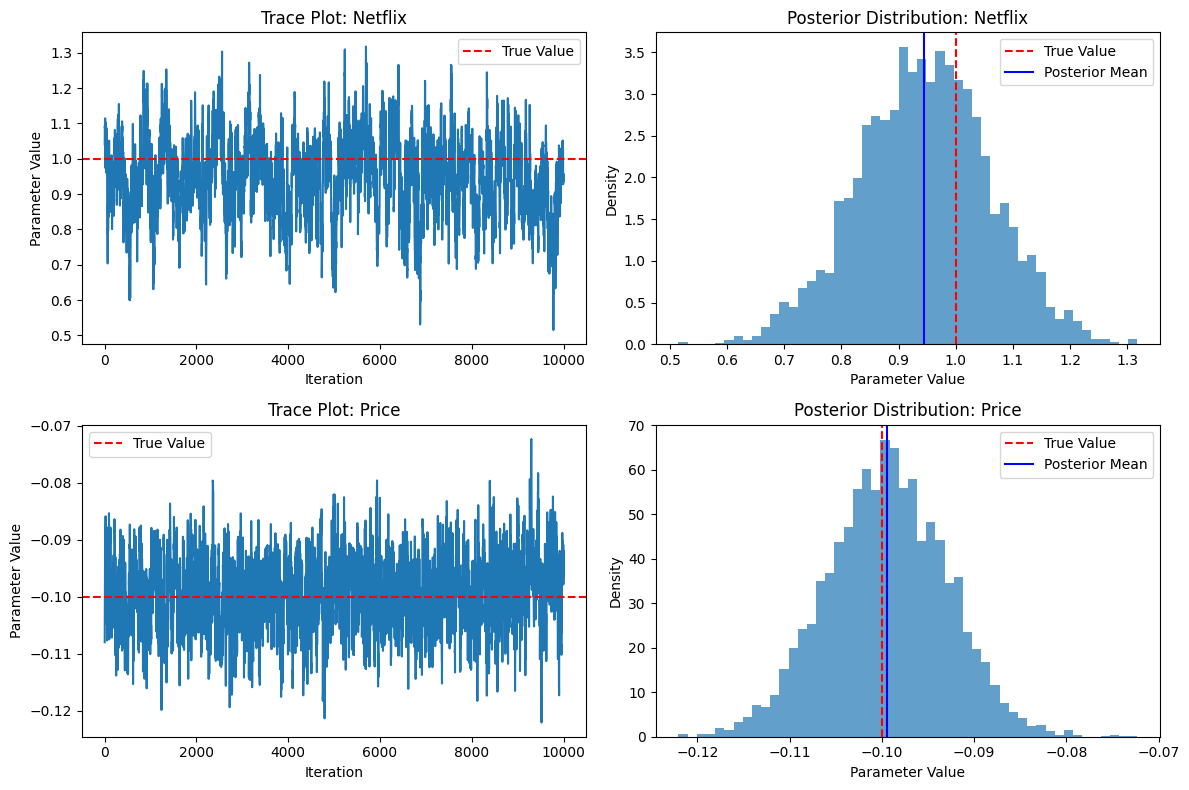

In [21]:
import matplotlib.pyplot as plt
# Create trace plots and histograms for Netflix parameter (index 0)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Netflix parameter
param_idx = 0
param_name = param_names[param_idx]

# Trace plot
axes[0, 0].plot(samples[:, param_idx])
axes[0, 0].set_title(f'Trace Plot: {param_name.title()}')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Parameter Value')
axes[0, 0].axhline(y=1.0, color='red', linestyle='--', label='True Value')
axes[0, 0].legend()

# Histogram
axes[0, 1].hist(samples[:, param_idx], bins=50, density=True, alpha=0.7)
axes[0, 1].axvline(x=1.0, color='red', linestyle='--', label='True Value')
axes[0, 1].axvline(x=posterior_means[param_idx], color='blue', linestyle='-', label='Posterior Mean')
axes[0, 1].set_title(f'Posterior Distribution: {param_name.title()}')
axes[0, 1].set_xlabel('Parameter Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Price parameter (more interesting because it's on different scale)
param_idx = 3
param_name = param_names[param_idx]

# Trace plot
axes[1, 0].plot(samples[:, param_idx])
axes[1, 0].set_title(f'Trace Plot: {param_name.title()}')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Parameter Value')
axes[1, 0].axhline(y=-0.1, color='red', linestyle='--', label='True Value')
axes[1, 0].legend()

# Histogram
axes[1, 1].hist(samples[:, param_idx], bins=50, density=True, alpha=0.7)
axes[1, 1].axvline(x=-0.1, color='red', linestyle='--', label='True Value')
axes[1, 1].axvline(x=posterior_means[param_idx], color='blue', linestyle='-', label='Posterior Mean')
axes[1, 1].set_title(f'Posterior Distribution: {param_name.title()}')
axes[1, 1].set_xlabel('Parameter Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 6. Discussion

_todo: Suppose you did not simulate the data. What do you observe about the parameter estimates? What does $\beta_\text{Netflix} > \beta_\text{Prime}$ mean? Does it make sense that $\beta_\text{price}$ is negative?_

_todo: At a high level, discuss what change you would need to make in order to simulate data from --- and estimate the parameters of --- a multi-level (aka random-parameter or hierarchical) model. This is the model we use to analyze "real world" conjoint data._


In [22]:
print("\n=== COMPARISON OF MLE AND BAYESIAN RESULTS ===")
comparison_df = pd.DataFrame({
    'Parameter': param_names,
    'True_Value': [1.0, 0.5, -0.8, -0.1],
    'MLE_Estimate': np.round(beta_mle, 4),
    'MLE_SE': np.round(se_mle, 4),
    'Bayes_Mean': np.round(posterior_means, 4),
    'Bayes_SD': np.round(posterior_sds, 4)
})
print(comparison_df.to_string(index=False))

print("\n=== DISCUSSION POINTS ===")
print("1. Parameter Interpretation:")
print(f"   - Netflix coefficient ({beta_mle[0]:.3f}) > Prime coefficient ({beta_mle[1]:.3f})")
print("     This suggests consumers prefer Netflix over Amazon Prime, with Hulu as the reference.")
print("   - Negative price coefficient suggests consumers prefer lower prices (as expected).")
print("   - Negative ads coefficient suggests consumers prefer ad-free content.")

print(f"\n2. Model Performance:")
print(f"   - Both MLE and Bayesian approaches recover parameters close to true values")
print(f"   - MCMC acceptance rate: {acceptance_rate:.3f} (reasonable for this problem)")
print(f"   - Standard errors from both methods are quite similar")

print(f"\n3. For hierarchical/multi-level models:")
print("   - Would need to add individual-level random effects: β_i = β + u_i")
print("   - This requires modeling the distribution of u_i (typically multivariate normal)")
print("   - Estimation becomes more complex, often requiring specialized software")
print("   - Allows for heterogeneity in preferences across consumers")


=== COMPARISON OF MLE AND BAYESIAN RESULTS ===
Parameter  True_Value  MLE_Estimate  MLE_SE  Bayes_Mean  Bayes_SD
  netflix         1.0        0.9412  0.1110      0.9452    0.1146
    prime         0.5        0.5016  0.1111      0.5029    0.1144
      ads        -0.8       -0.7320  0.0878     -0.7268    0.0891
    price        -0.1       -0.0995  0.0063     -0.0995    0.0065

=== DISCUSSION POINTS ===
1. Parameter Interpretation:
   - Netflix coefficient (0.941) > Prime coefficient (0.502)
     This suggests consumers prefer Netflix over Amazon Prime, with Hulu as the reference.
   - Negative price coefficient suggests consumers prefer lower prices (as expected).
   - Negative ads coefficient suggests consumers prefer ad-free content.

2. Model Performance:
   - Both MLE and Bayesian approaches recover parameters close to true values
   - MCMC acceptance rate: 0.561 (reasonable for this problem)
   - Standard errors from both methods are quite similar

3. For hierarchical/multi-level m